In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
import wandb
wandb.login()

wandb: Currently logged in as: sahaana (use `wandb login --relogin` to force relogin)


True

# Imports 

In [4]:
import pandas as pd
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
from transformers import AutoTokenizer, DistilBertModel

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [5]:
import sys
#sys.path.append('/lfs/1/sahaana/enrichment/enrich/utils')
sys.path.append('/lfs/1/sahaana/enrichment/ember/utils')
 
    
from embedding_datasets import IMDBWikiDataset, EmberEvalDataset
from embedding_models import TripletSingleBERTModel
from embedding_utils import param_header, tokenize_batch  
from embedding_runner import train_model, eval_model
#from model_utils import MatchedDatasetTriplets, param_header_bert, tokenize_batch   
#from models import BatchedTripletSingleTowerModel, BatchedTripletSingleBERTModel
#from model_runner import train_model, eval_model
from knn_utils import FaissKNeighbors, knn_IMDB_wiki_recall #, knn_matching_accuracy, find_perfect_recall

In [6]:
%load_ext autoreload
%autoreload 2

# Load Processed (cleaned, aligned) Datasets

In [7]:
left = '/lfs/1/sahaana/enrichment/data/imdb_wiki/train_tableA_processed.pkl'
right = '/lfs/1/sahaana/enrichment/data/imdb_wiki/train_tableB_processed.pkl'

left = pd.read_pickle(left)
right = pd.read_pickle(right)

In [8]:
left

,tconst,primaryTitle,category,isAdult,titleType,originalTitle,runtimeMinutes,genres,startYear,nconst,job,characters,primaryName,primaryProfession,knownForTitles,merged_all
IMDB_ID,,,,,,,,,,,,,,,,
tt2825120,tt2825120,Crows Explode,"director, producer, writer, actress, actor, ac...",0,movie,Kurôzu Explode,129,Action,2014,"nm0870313, nm0945451, nm2626759, nm5620173, nm...","\N, producer, manga, \N, \N, \N, \N, \N, \N, \N","\N, \N, \N, [""Mie Uchida""], [""Kaburagi""], [""Ke...","Toshiaki Toyoda, Mataichirô Yamamoto, Hiroshi ...","director,writer,cinematographer, producer,writ...","tt2281293,tt0370244,tt0309291,tt0460845, tt092...",[SEP] tconst tt2825120 [SEP] primaryTitle C...
tt0403455,tt0403455,Roll Bounce,"producer, producer, composer, actress, directo...",0,movie,Roll Bounce,112,"Comedy,Drama,Music",2005,"nm0863387, nm0854052, nm0734755, nm0328709, nm...","producer, producer, \N, \N, \N, \N, \N, \N, wr...","\N, \N, \N, [""Naomi Phillips""], \N, [""Xavier '...","George Tillman Jr., Robert Teitel, Nile Rodger...","producer,director,writer, producer,writer, sou...","tt5580266,tt0472198,tt0203019,tt2113075, tt362...",[SEP] tconst tt0403455 [SEP] primaryTitle R...
tt0418460,tt0418460,Aitraaz,"actress, actor, actress, actor, writer, produc...",0,movie,Aitraaz,160,"Drama,Romance,Thriller",2004,"nm0004626, nm0700869, nm1231899, nm0474774, nm...","\N, \N, \N, \N, screenplay, producer, \N, \N, ...","[""Priya Saxena""], [""Ranjit Roy""], [""Mrs. Sonia...","Kareena Kapoor, Amrish Puri, Priyanka Chopra, ...","actress,soundtrack,music_department, actor,mus...","tt1562871,tt0488414,tt1093370,tt1187043, tt009...",[SEP] tconst tt0418460 [SEP] primaryTitle A...
tt0477139,tt0477139,Wristcutters: A Love Story,"actor, actor, actor, producer, actor, producer...",0,movie,Wristcutters: A Love Story,88,"Comedy,Drama,Fantasy",2006,"nm0297578, nm0004715, nm0001823, nm1353543, nm...","\N, \N, \N, producer, \N, producer, producer, ...","[""Zia""], [""Messiah""], [""Kneller""], \N, [""Eugen...","Patrick Fugit, Will Arnett, Tom Waits, Adam Sh...","actor,producer,camera_department, actor,produc...","tt0181875,tt2267998,tt0332375,tt0477139, tt036...",[SEP] tconst tt0477139 [SEP] primaryTitle W...
tt0189630,tt0189630,Kadosh,"cinematographer, composer, actor, actor, direc...",0,movie,Kadosh,110,Drama,1999,"nm0005655, nm0778555, nm0368701, nm0709355, nm...","\N, \N, \N, \N, \N, producer, \N, writer, \N, \N","\N, \N, [""Meïr""], [""Yossef""], \N, \N, \N, \N, ...","Renato Berta, Louis Sclavis, Yoram Hattab, Uri...","cinematographer,camera_department,director, co...","tt0108167,tt0089902,tt0092593,tt1365490, tt018...",[SEP] tconst tt0189630 [SEP] primaryTitle K...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt0154420,tt0154420,The Celebration,"editor, actor, actor, actor, actress, director...",0,movie,Festen,105,Drama,1998,"nm0652020, nm0860947, nm0605786, nm0488917, nm...","\N, \N, \N, \N, \N, \N, screenplay, producer, ...","\N, [""Christian""], [""Faderen - Helge Klingenfe...","Valdís Óskarsdóttir, Ulrich Thomsen, Henning M...","editor,editorial_department,director, actor,pr...","tt1039891,tt0338013,tt0154420,tt1524553, tt041...",[SEP] tconst tt0154420 [SEP] primaryTitle T...
tt9358106,tt9358106,Dolce fine giornata,"actress, actor, writer, actress, composer, act...",0,movie,Dolce fine giornata,92,Drama,2019,"nm0417370, nm0145951, nm9638802, nm0810738, nm...","\N, \N, \N, \N, \N, \N, \N, associate screenpl...","[""Maria Linde""], [""Antonio Linde""], \N, [""Anna...","Krystyna Janda, Antonio Catania, Szczepan Twar...","actress,director,writer, actor, writer,miscell...","tt0084548,tt0479258,tt0114118,tt0441074, tt014...",[SEP] tconst tt9358106 [SEP] primaryTitle D...
tt6284256,tt6284256,Knuckleball,"actor, producer, actor, actress, producer, act...",0,movie,Knuckleball,89,Thriller,2018,"nm0000461, nm4811901, nm1089325, nm1182008, nm...","\N, producer, \N, \N, producer, \N, \N, \N, st...","[""Jacob""], \N, [""Dixon""], [""Mary""], \N, [""Henr

In [9]:
right

,title,wikisummary,merged_all
QID,,,
Q14639047,Crows Explode,"Crows Explode ( EXPLODE, Kurzu Explode) is a 2...",[SEP] title Crows Explode [SEP] wikisummary...
Q2120775,Roll Bounce,Roll Bounce is a 2005 American comedy-drama fi...,[SEP] title Roll Bounce [SEP] wikisummary R...
Q3413700,Aitraaz,Aitraaz (English: Objection) is a 2004 Indian ...,[SEP] title Aitraaz [SEP] wikisummary Aitra...
Q2002073,Wristcutters: A Love Story,Wristcutters: A Love Story is a 2006 American ...,[SEP] title Wristcutters: A Love Story [SEP]...
Q3191800,Kadosh,Kadosh (Hebrew: ) (lit. Sacred) is a 1999 fil...,[SEP] title Kadosh [SEP] wikisummary Kadosh...
...,...,...,...
Q841958,Festen,Festen (also known as The Celebration) is a 19...,[SEP] title Festen [SEP] wikisummary Festen...
Q64768058,Dolce Fine Giornata,Dolce Fine Giornata (Polish: Sodki koniec dnia...,[SEP] title Dolce Fine Giornata [SEP] wikis...
Q77733171,Knuckleball (2018 film),Knuckleball is a 2018 Canadian thriller film w...,[SEP] title Knuckleball (2018 film) [SEP] w...


(array([1.400e+01, 2.400e+01, 2.600e+01, 1.100e+01, 4.000e+00, 2.700e+01,
        2.700e+01, 2.500e+01, 2.400e+01, 6.000e+00, 2.400e+01, 2.300e+01,
        4.100e+01, 4.500e+01, 7.000e+00, 4.500e+01, 2.800e+01, 5.500e+01,
        3.900e+01, 1.600e+01, 4.000e+01, 3.500e+01, 7.000e+01, 3.400e+01,
        5.400e+01, 5.800e+01, 3.900e+01, 6.600e+01, 3.300e+01, 8.300e+01,
        3.700e+01, 8.500e+01, 1.230e+02, 4.000e+01, 8.800e+01, 7.200e+01,
        1.530e+02, 1.860e+02, 1.080e+02, 1.900e+02, 1.330e+02, 3.530e+02,
        2.320e+02, 4.960e+02, 5.320e+02, 6.040e+02, 2.016e+03, 1.506e+03,
        4.172e+03, 2.599e+03, 5.297e+03, 4.899e+03, 2.137e+03, 3.602e+03,
        1.416e+03, 2.180e+03, 1.405e+03, 5.390e+02, 7.510e+02, 2.460e+02,
        3.840e+02, 1.010e+02, 1.660e+02, 1.200e+02, 3.500e+01, 6.300e+01,
        2.400e+01, 3.000e+01, 2.300e+01, 1.000e+01, 1.600e+01, 6.000e+00,
        1.100e+01, 6.000e+00, 8.000e+00, 8.000e+00, 4.000e+00, 3.000e+00,
        2.000e+00, 2.000e+00, 0.000e+0

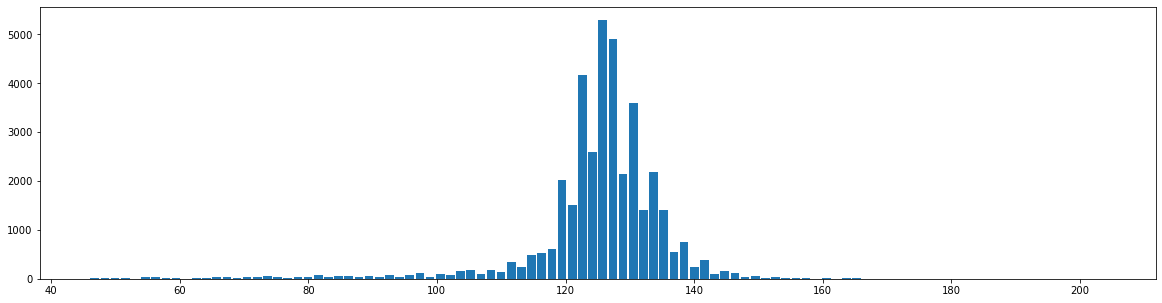

In [10]:
plt.figure(figsize=(20,5))
plt.hist(left['merged_all'].apply(lambda x: len(x.split())), bins=100, rwidth = .85)

(array([1.920e+02, 1.635e+03, 2.543e+03, 3.452e+03, 3.234e+03, 3.578e+03,
        2.870e+03, 2.894e+03, 2.244e+03, 2.251e+03, 1.833e+03, 1.407e+03,
        1.323e+03, 1.014e+03, 1.011e+03, 7.460e+02, 7.230e+02, 5.630e+02,
        5.880e+02, 4.360e+02, 4.260e+02, 3.530e+02, 2.580e+02, 3.030e+02,
        2.200e+02, 2.380e+02, 2.030e+02, 1.650e+02, 1.240e+02, 1.340e+02,
        1.280e+02, 1.140e+02, 1.320e+02, 9.000e+01, 9.800e+01, 7.400e+01,
        5.700e+01, 7.000e+01, 5.900e+01, 4.700e+01, 5.200e+01, 4.900e+01,
        3.600e+01, 4.100e+01, 3.100e+01, 2.900e+01, 2.900e+01, 1.800e+01,
        1.200e+01, 1.600e+01, 1.100e+01, 1.100e+01, 1.600e+01, 5.000e+00,
        4.000e+00, 8.000e+00, 1.100e+01, 8.000e+00, 5.000e+00, 5.000e+00,
        4.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 0.000e+0

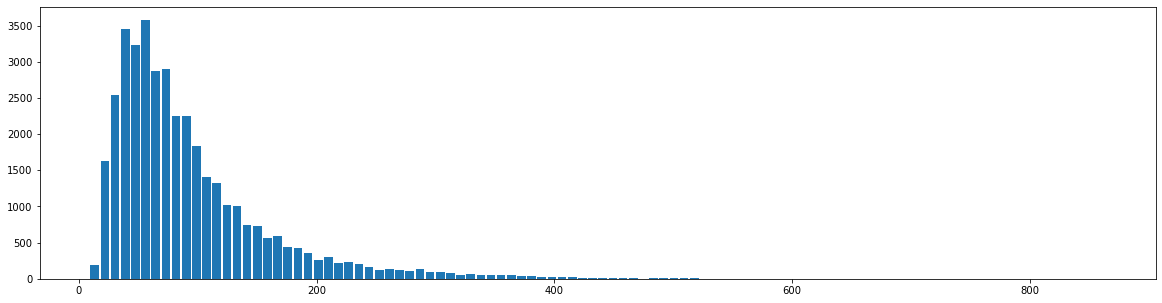

In [11]:
plt.figure(figsize=(20,5))
plt.hist(right['merged_all'].apply(lambda x: len(x.split())), bins=100, rwidth = .85)

# Prepping Data Indices

In [12]:
train_df = '/lfs/1/sahaana/enrichment/data/imdb_wiki/supervision_train.pkl'
train_df = pd.read_pickle(train_df)

val_df = '/lfs/1/sahaana/enrichment/data/imdb_wiki/supervision_test.pkl'
val_df = pd.read_pickle(val_df)

## Model H Params

In [13]:
epochs = 1
batch_size = 8
final_size = 200
lr = .00001
tl_margin = 1.0
tl_p = 2
pool_type = "CLS"
column = "merged_all"
shuffle = True
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer_max_length = 512
compute_val = False
train_size = int(len(train_df)/8)
    

bert_path='/lfs/1/sahaana/enrichment/ember/pretraining/models/imdb_wiki-uncased-masked-ALL-BM25'
bert_model = DistilBertModel.from_pretrained(bert_path, return_dict=True)

model_name = f'imdb_wiki-uncased-masked-ALL-BM25'

## DataLoaders

In [14]:
train_data = DataLoader(IMDBWikiDataset(left, right, len(train_df), column, train_df), 
                        batch_size=batch_size,
                        shuffle = shuffle
                        )

val_data = None 
"""DataLoader(SQuADDataset(left, right, len(val_df), column, val_df), 
                       batch_size=batch_size,
                       shuffle = False
                      )"""

'DataLoader(SQuADDataset(left, right, len(val_df), column, val_df), \n                       batch_size=batch_size,\n                       shuffle = False\n                      )'

## Init and Run Model

In [15]:
triplet_loss = nn.TripletMarginLoss(margin=tl_margin, p=tl_p)
losses = []
val_losses = []
model = TripletSingleBERTModel(final_size, pool_type, bert_path)
optimizer = optim.AdamW(model.parameters(), lr=lr)#optim.SGD(model.parameters(), lr=lr)

In [16]:
save_dir = param_header(batch_size, final_size, lr, pool_type, epochs, train_size)
save_dir = f'models/{model_name}/{save_dir}/'

In [17]:
wandb.init(project=model_name)

In [18]:
train_model(model, 
            tokenizer, 
            tokenize_batch, 
            train_data, 
            val_data, 
            triplet_loss, 
            optimizer, 
            epochs, 
            losses, 
            val_losses, 
            save_dir, 
            compute_val, 
            tokenizer_max_length = tokenizer_max_length)

RuntimeError: CUDA out of memory. Tried to allocate 82.00 MiB (GPU 0; 11.75 GiB total capacity; 9.74 GiB already allocated; 58.94 MiB free; 10.60 GiB reserved in total by PyTorch)

In [20]:
model.load_state_dict(torch.load('/lfs/1/sahaana/enrichment/ember/notebooks/embedding/models/imdb_wiki-uncased-masked-ALL-BM25/batch_size-8-final_size-200-opt_lr-1e-05-pooling-CLS-epochs-1-train-4781/19-04-19-02-21'))

<All keys matched successfully>

# k-NN Model Performance

In [107]:
left_eval = '/lfs/1/sahaana/enrichment/data/imdb_wiki/dev_tableA_processed.pkl'
right_eval = '/lfs/1/sahaana/enrichment/data/imdb_wiki/dev_tableB_processed.pkl'
test = '/lfs/1/sahaana/enrichment/data/imdb_wiki/supervision_test.pkl'

left_eval = pd.read_pickle(left_eval)
right_eval = pd.read_pickle(right_eval)
test_df = pd.read_pickle(test)

In [108]:
#PATH = "models/single-tower-BERT-triplet-model/batch_size-8-final_size-50-opt_lr-0.0001-tloss_margin-1.0-tloss_p-2-pooling-CLS-shuffle-True00-35-05-01-21"
#model.load_state_dict(torch.load(PATH))

left_eval_data = DataLoader(EmberEvalDataset(left_eval, column, indexed=True), 
                       batch_size=batch_size,
                       shuffle = False
                      )
right_eval_data = DataLoader(EmberEvalDataset(right_eval, column, indexed=True), 
                       batch_size=batch_size,
                       shuffle = False
                      )

In [109]:
left_index, left_embeddings = eval_model(model, tokenizer, left_eval_data, tokenizer_max_length=512)
right_index, right_embeddings = eval_model(model, tokenizer, right_eval_data, tokenizer_max_length=512)

In [110]:
knn = FaissKNeighbors(k=30)
knn.fit(right_embeddings)
neib = knn.kneighbors(left_embeddings)

In [111]:
for k in range(1,31):
    avg, count, MRR, results, MRR_results = knn_IMDB_wiki_recall(neib[0], neib[1], test_df, left_index, right_index, k=k)
    print(f"k: {k} \t avg: {avg} \t count: {count} \t MRR: {MRR}")

k: 1 	 avg: 0.9614137822858936 	 count: 9194 	 MRR: 0.9614137822858936
k: 2 	 avg: 0.972916448813134 	 count: 9304 	 MRR: 0.9671651155495138
k: 3 	 avg: 0.9787723517724564 	 count: 9360 	 MRR: 0.9691170832026214
k: 4 	 avg: 0.9807591759907979 	 count: 9379 	 MRR: 0.9696137892572068
k: 5 	 avg: 0.9832688486876503 	 count: 9403 	 MRR: 0.9701157237965772
k: 6 	 avg: 0.9847328244274809 	 count: 9417 	 MRR: 0.9703597197532154
k: 7 	 avg: 0.9855693819930984 	 count: 9425 	 MRR: 0.9704792279768752
k: 8 	 avg: 0.9868242183415247 	 count: 9437 	 MRR: 0.9706360825204285
k: 9 	 avg: 0.9876607759071421 	 count: 9445 	 MRR: 0.9707290333610527
k: 10 	 avg: 0.9884973334727596 	 count: 9453 	 MRR: 0.9708126891176143
k: 11 	 avg: 0.9889156122555683 	 count: 9457 	 MRR: 0.9708507144615062
k: 12 	 avg: 0.9892293213426749 	 count: 9460 	 MRR: 0.9708768568854318
k: 13 	 avg: 0.9894384607340793 	 count: 9462 	 MRR: 0.9708929445309243
k: 14 	 avg: 0.989856739516888 	 count: 9466 	 MRR: 0.9709228215868392
k: 

In [112]:
df = defaultdict(list)
for k in range(1,31):
    avg, count, MRR, results, MRR_results = knn_IMDB_wiki_recall(neib[0], neib[1], test_df, left_index, right_index, k=k)
    print(f"k: {k} \t avg: {avg} \t count: {count} \t MRR: {MRR}")
    df['k'].append(k)
    df['avg'].append(avg)
    df['count'].append(count)
    df['MRR'].append(MRR)
    df['results'].append(results)
    df['MRR_results'].append(MRR_results)

k: 1 	 avg: 0.9614137822858936 	 count: 9194 	 MRR: 0.9614137822858936
k: 2 	 avg: 0.972916448813134 	 count: 9304 	 MRR: 0.9671651155495138
k: 3 	 avg: 0.9787723517724564 	 count: 9360 	 MRR: 0.9691170832026214
k: 4 	 avg: 0.9807591759907979 	 count: 9379 	 MRR: 0.9696137892572068
k: 5 	 avg: 0.9832688486876503 	 count: 9403 	 MRR: 0.9701157237965772
k: 6 	 avg: 0.9847328244274809 	 count: 9417 	 MRR: 0.9703597197532154
k: 7 	 avg: 0.9855693819930984 	 count: 9425 	 MRR: 0.9704792279768752
k: 8 	 avg: 0.9868242183415247 	 count: 9437 	 MRR: 0.9706360825204285
k: 9 	 avg: 0.9876607759071421 	 count: 9445 	 MRR: 0.9707290333610527
k: 10 	 avg: 0.9884973334727596 	 count: 9453 	 MRR: 0.9708126891176143
k: 11 	 avg: 0.9889156122555683 	 count: 9457 	 MRR: 0.9708507144615062
k: 12 	 avg: 0.9892293213426749 	 count: 9460 	 MRR: 0.9708768568854318
k: 13 	 avg: 0.9894384607340793 	 count: 9462 	 MRR: 0.9708929445309243
k: 14 	 avg: 0.989856739516888 	 count: 9466 	 MRR: 0.9709228215868392
k: 

In [116]:
left_embeddings

array([[ 0.41167977,  0.27279446,  0.05214804, ...,  0.03416813,
         0.11913989, -0.14742239],
       [ 0.26182982,  0.10862146, -0.3072921 , ..., -0.14531109,
        -0.22872989,  0.04964525],
       [-0.23675321,  0.0370113 ,  0.3828806 , ..., -0.32902685,
         0.16414087, -0.24634019],
       ...,
       [ 0.27642626, -0.22639656, -0.56565845, ..., -0.62979037,
        -0.0686643 , -0.09559718],
       [ 0.3537606 ,  0.1268345 , -0.12116482, ..., -0.24872741,
        -0.12208895, -0.00258588],
       [-0.4377644 ,  0.43698618, -0.23624247, ..., -0.28407842,
        -0.48860994, -0.8177455 ]], dtype=float32)

# Downstream Thing

In [120]:
left_eval = '/lfs/1/sahaana/enrichment/data/imdb_wiki/dev_tableA_processed.pkl'
left_train = '/lfs/1/sahaana/enrichment/data/imdb_wiki/train_tableA_processed.pkl'
right_train = '/lfs/1/sahaana/enrichment/data/imdb_wiki/train_tableB_processed.pkl'

left_eval = pd.read_pickle(left_eval)
left_train = pd.read_pickle(left_train)
right_train = pd.read_pickle(right_train)
test_df = pd.read_pickle(test)

In [121]:
#PATH = "models/single-tower-BERT-triplet-model/batch_size-8-final_size-50-opt_lr-0.0001-tloss_margin-1.0-tloss_p-2-pooling-CLS-shuffle-True00-35-05-01-21"
#model.load_state_dict(torch.load(PATH))

left_eval_data = DataLoader(EmberEvalDataset(left_eval, column, indexed=True), 
                       batch_size=batch_size,
                       shuffle = False
                      )

left_train_data = DataLoader(EmberEvalDataset(left_train, column, indexed=True), 
                       batch_size=batch_size,
                       shuffle = False
                      )

right_train_data = DataLoader(EmberEvalDataset(right_train, column, indexed=True), 
                       batch_size=batch_size,
                       shuffle = False
                      )

In [122]:
left_eval_index, left_eval_embeddings = eval_model(model, tokenizer, left_eval_data, tokenizer_max_length=512)
left_train_index, left_train_embeddings = eval_model(model, tokenizer, left_train_data, tokenizer_max_length=512)
right_train_index, right_train_embeddings = eval_model(model, tokenizer, right_train_data, tokenizer_max_length=512)

In [126]:
# knn from test query to corpus
knn = FaissKNeighbors(k=30)
knn.fit(right_train_embeddings)
neib_eval = knn.kneighbors(left_eval_embeddings)

In [127]:
# knn from corpus to train query
knn = FaissKNeighbors(k=30)
knn.fit(left_train_embeddings)
neib_train = knn.kneighbors(right_train_embeddings)

In [142]:
right_train_index

array(['Q14639047', 'Q2120775', 'Q3413700', ..., 'Q77733171', 'Q1037699',
       'Q590308'], dtype='<U9')

In [172]:
wiki_to_imdb_train = pd.DataFrame(left_train_index[neib_train[1]],right_train_index)
test_imdb_to_wiki = pd.DataFrame(right_train_index[neib_eval[1]],left_eval_index)

In [173]:
test_imdb_to_wiki # left_eval.loc['tt0038427'] -> right_train.loc['Q684216']

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
tt0038427,Q684216,Q1367163,Q1541607,Q1251157,Q1129813,Q19873427,Q241876,Q48674550,Q5227934,Q6469201,...,Q3225457,Q229547,Q1118983,Q1199692,Q3282939,Q31971,Q283319,Q1162433,Q2576178,Q1333248
tt1613092,Q39071657,Q3783275,Q23755410,Q3024219,Q19320969,Q62901985,Q30101323,Q5652974,Q6654640,Q16972771,...,Q8029053,Q6690026,Q2717510,Q48672779,Q7798837,Q6495199,Q1058682,Q475136,Q1279290,Q1462822
tt1327820,Q1764575,Q17505968,Q477299,Q1162380,Q897618,Q17165619,Q218496,Q15266284,Q1140281,Q658787,...,Q6378229,Q338253,Q32303,Q4147895,Q12128483,Q27158930,Q1218226,Q4762042,Q10533236,Q11967418
tt5462602,Q27888464,Q22058439,Q59304927,Q22074948,Q42531263,Q28369571,Q31271054,Q15208268,Q21646414,Q29079039,...,Q58815041,Q19824669,Q38463395,Q30521583,Q20899742,Q27703157,Q21450483,Q27703215,Q13562077,Q9086870
tt0047167,Q1078890,Q10501864,Q3485336,Q217189,Q239756,Q842067,Q464651,Q221354,Q917248,Q265203,...,Q901217,Q753141,Q1765389,Q5310123,Q1171209,Q6486765,Q10594905,Q1170128,Q830874,Q327775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt0060865,Q849045,Q2451844,Q3423295,Q1333588,Q3228579,Q2055558,Q3421533,Q1968139,Q3221469,Q111788,...,Q7733739,Q1609372,Q834168,Q3363575,Q45386,Q5069544,Q630237,Q1766000,Q2420393,Q7734417
tt0081111,Q550298,Q4943314,Q2797534,Q374207,Q7774846,Q1215150,Q1753610,Q3107638,Q5227902,Q1395484,...,Q7695270,Q818928,Q4689527,Q2625472,Q5526696,Q3137753,Q705145,Q1120536,Q1876361,Q1127828
tt0410400,Q5151551,Q2566986,Q432102,Q4188983,Q4730112,Q6673034,Q3822873,Q3283639,Q3365581,Q4327809,...,Q4353163,Q7044643,Q3738695,Q1659525,Q3285147,Q7580758,Q582147,Q917400,Q1624863,Q2653383
tt0107611,Q538909,Q240899,Q6290264,Q6651554,Q1215976,Q589713,Q191040,Q134773,Q1209853,Q6928348,...,Q508937,Q1148134,Q5306553,Q1235550,Q1237683,Q1421355,Q1989864,Q5583521,Q16204126,Q3296090


In [174]:
wiki_to_imdb_train # right_train.loc['Q14639047'] -> left_train.loc['tt2825120']

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
Q14639047,tt2825120,tt1669604,tt2124014,tt2409302,tt3853452,tt2072230,tt4146350,tt4440114,tt3345474,tt3345472,...,tt2347144,tt3688018,tt3455204,tt0856797,tt2403867,tt2428818,tt4949100,tt3675748,tt2444942,tt2409300
Q2120775,tt0403455,tt0272338,tt0186894,tt0119336,tt0373469,tt0315824,tt1151309,tt0116324,tt0165710,tt0206636,...,tt1229360,tt0415306,tt0246875,tt1393020,tt0100504,tt0120014,tt0114469,tt0790804,tt0385002,tt1291183
Q3413700,tt0418460,tt0347332,tt0422091,tt0278291,tt0293342,tt0211126,tt0409724,tt0152836,tt0391274,tt0369516,...,tt0114234,tt0323013,tt0284328,tt0374271,tt0409527,tt0349333,tt0255713,tt0255097,tt0319020,tt0406977
Q2002073,tt0477139,tt1702009,tt0772152,tt0954327,tt1762248,tt1511489,tt1124401,tt0185101,tt0452345,tt0758752,...,tt0984204,tt0888019,tt0429277,tt0447166,tt0853155,tt0113729,tt0236034,tt0191654,tt0460898,tt0886531
Q3191800,tt0189630,tt0112665,tt0374036,tt0095433,tt0426155,tt0782867,tt0109751,tt0268696,tt1093814,tt0317842,...,tt0133351,tt0255094,tt0391857,tt0092678,tt0379577,tt0425321,tt1043869,tt0111055,tt0423310,tt1406160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q841958,tt0154420,tt0268374,tt0154421,tt0457655,tt0117817,tt0315543,tt0436319,tt0258291,tt0164711,tt0273326,...,tt0090610,tt0386582,tt0201265,tt0387233,tt0101927,tt0204932,tt0092160,tt0365810,tt0093524,tt0125507
Q64768058,tt9358106,tt4834762,tt6543652,tt6415416,tt8738964,tt1927068,tt2282829,tt5936692,tt5328350,tt5278832,...,tt1994537,tt1927077,tt2577150,tt2209386,tt2718492,tt1623753,tt2719094,tt5049636,tt2043979,tt1324055
Q77733171,tt6284256,tt4725842,tt5990066,tt6547170,tt5208950,tt6061074,tt4173306,tt5740806,tt5428666,tt5465970,...,tt6068554,tt9495224,tt5926990,tt5992138,tt3401882,tt6205872,tt7427856,tt5044656,tt7690670,tt2548396
Q1037699,tt0997274,tt1221151,tt2653264,tt0493247,tt0371310,tt1632547,tt1158278,tt1965134,tt0959314,tt0781084,...,tt1705064,tt1606761,tt1776196,tt0304262,tt3029558,tt1587234,tt1422675,tt1727825,tt1292561,tt1590959


In [138]:
train_ratings = pd.read_pickle('/lfs/1/sahaana/enrichment/data/imdb_wiki/ratings_train.pkl')
test_ratings = pd.read_pickle('/lfs/1/sahaana/enrichment/data/imdb_wiki/ratings_test.pkl')

In [175]:
closest_corpus_to_test = test_imdb_to_wiki[0]

In [186]:
closest_train_to_closest_corpus_to_test = wiki_to_imdb_train.loc[closest_corpus_to_test][0]

In [193]:
est_ratings = train_ratings.loc[closest_train_to_closest_corpus_to_test]['averageRating']
true_ratings = test_ratings['averageRating']

In [311]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(est_ratings, true_ratings)
mse

1.689675833943323

## Averaged thing

In [388]:
for avg in [1,10,15,20, 25, 30]:
    avged_cctt = test_imdb_to_wiki[np.arange(avg)]
    avged_cctt
    rates = []
    for colm in test_imdb_to_wiki[np.arange(avg)]:
        avged_cttcctt =  wiki_to_imdb_train.loc[avged_cctt[colm]][0]
        rates.append(train_ratings.loc[avged_cttcctt]['averageRating'])
    final_predicted = np.mean(np.vstack(rates), axis=0)   
    print(f"Avg: {avg} \t MSE: {mean_squared_error(final_predicted, true_ratings)}")

Avg: 1 	 MSE: 1.689675833943323
Avg: 10 	 MSE: 0.9243229007633588
Avg: 15 	 MSE: 0.8992520245854974
Avg: 20 	 MSE: 0.8898158004810207
Avg: 25 	 MSE: 0.8836823925546378
Avg: 30 	 MSE: 0.8812121823695493


# Downstream Baseline 

## LGBM

In [209]:
import lightgbm as lgb

In [213]:
ratings_train_dataset = pd.merge(train_ratings, left_train, on='IMDB_ID')
ratings_test_dataset = pd.merge(test_ratings, left_eval, on='IMDB_ID')

In [455]:
X_train = left_train[['tconst', 'primaryTitle', 'category', 'isAdult', 'titleType',
       'originalTitle', 'runtimeMinutes', 'genres', 'startYear', 'nconst',
       'job', 'characters', 'primaryName', 'primaryProfession',
       'knownForTitles']]
X_test = left_eval[['tconst', 'primaryTitle', 'category', 'isAdult', 'titleType',
       'originalTitle', 'runtimeMinutes', 'genres', 'startYear', 'nconst',
       'job', 'characters', 'primaryName', 'primaryProfession',
       'knownForTitles']]

X_train = left_train[['primaryTitle', 'isAdult', 'titleType',
       'originalTitle', 'runtimeMinutes', 'genres', 'startYear']]
X_test = left_eval[['primaryTitle','isAdult', 'titleType',
       'originalTitle', 'runtimeMinutes', 'genres', 'startYear']]

y_train = train_ratings['averageRating']
y_test = test_ratings['averageRating']

In [456]:
for c in X_train.columns:
    col_type = X_train[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_train[c] = X_train[c].astype('category')
        X_test[c] = X_test[c].astype('category')


<ipython-input-456-6e23438304fc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[c] = X_train[c].astype('category')
<ipython-input-456-6e23438304fc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[c] = X_test[c].astype('category')


In [457]:
l2_reg_params={}
l2_reg_params['learning_rate'] = 0.03
l2_reg_params['boosting_type'] = 'gbdt' 
l2_reg_params['objective'] = 'regression'
l2_reg_params['metric'] = 'mean_squared_error' 
l2_reg_params['max_depth'] = 10
l2_reg_params['num_leaves'] = 100

In [458]:
clf = lgb.LGBMRegressor(**l2_reg_params)
#clf = lgb.LGBMRegressor(**hyper_params)

In [459]:
clf.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.03, max_depth=10, metric='mean_squared_error',
              num_leaves=100, objective='regression')

In [460]:
lgb_predicted = clf.predict(X_test)

In [461]:
mean_squared_error(lgb_predicted, y_test)

0.8147876921513072

In [462]:
X_train

,primaryTitle,isAdult,titleType,originalTitle,runtimeMinutes,genres,startYear
IMDB_ID,,,,,,,
tt2825120,Crows Explode,0,movie,Kurôzu Explode,129,Action,2014
tt0403455,Roll Bounce,0,movie,Roll Bounce,112,"Comedy,Drama,Music",2005
tt0418460,Aitraaz,0,movie,Aitraaz,160,"Drama,Romance,Thriller",2004
tt0477139,Wristcutters: A Love Story,0,movie,Wristcutters: A Love Story,88,"Comedy,Drama,Fantasy",2006
tt0189630,Kadosh,0,movie,Kadosh,110,Drama,1999
...,...,...,...,...,...,...,...
tt0154420,The Celebration,0,movie,Festen,105,Drama,1998
tt9358106,Dolce fine giornata,0,movie,Dolce fine giornata,92,Drama,2019
tt6284256,Knuckleball,0,movie,Knuckleball,89,Thriller,2018


## Neural Network

In [378]:
from downstream_utils import DownstreamRatingDataset, SingleBERTModel, tokenize_ds

In [379]:
model = SingleBERTModel(final_size=1, pooling="CLS", bert_path="distilbert-base-uncased", pool_activation='gelu')
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [380]:
loss = torch.nn.MSELoss()
epochs = 1
batch_size = 4
optimizer = optim.AdamW(model.parameters(), lr=.00001)#optim.SGD(model.parameters(), lr=lr)

downstream_train_data = DataLoader(DownstreamRatingDataset(ratings_train_dataset, indexed=True), 
                                    batch_size=batch_size,
                                    shuffle = False
                                    )

In [381]:
losses = []
for epoch in range(epochs):
    model.train()
    model.cuda()
    for i, dd in enumerate(downstream_train_data):
        batch, masks, labels = tokenize_ds(dd, tokenizer)
        labels = labels.float().cuda()
        batch = batch.cuda()
        masks = masks.cuda()
        optimizer.zero_grad()
        outbatch = model(batch, masks)
        computed_loss = loss(outbatch, labels)
        computed_loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            losses.append(computed_loss.cpu().detach().item())
        if i % 500 == 0:
            print(losses[-1])
        
    

/future/u/sahaana/miniconda3/envs/ember_pip/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


43.60020446777344
1.3679211139678955


KeyboardInterrupt: 

In [ ]:
plt.plot(losses)

In [ ]:
downstream_test_data = DataLoader(DownstreamRatingDataset(ratings_test_dataset, indexed=True), 
                                    batch_size=batch_size,
                                    shuffle = False
                                    )

In [ ]:
predicted_values = []
actual_values = []
running_loss = 0
model.eval()
with torch.no_grad():
    for i, dd in enumerate(downstream_test_data):
        batch, masks, labels = tokenize_ds(dd, tokenizer)
        labels = labels.float().cuda()
        batch = batch.cuda()
        masks = masks.cuda()
        outbatch = model(batch, masks)
        computed_loss = loss(outbatch, labels)
        running_loss += computed_loss.cpu().detach().item() * batch_size
        predicted_values.append(outbatch.cpu().detach().numpy())  
        actual_values.append(labels.cpu().detach().numpy())  

In [ ]:
running_loss, running_loss/i

In [ ]:
# Trial 2; 2 epoch
mse = mean_squared_error(np.vstack(predicted_values), np.hstack(actual_values))
mse

In [306]:
# Trial 1; 1 epoch
mse = mean_squared_error(np.vstack(predicted_values), np.hstack(actual_values))
mse

1.0636544